### 1D Burger Equation NFTM Simulator using a CNN as the controller.

The Burger equation in 1-dimension is given by:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$


* We want to build a NFTM with a CNN-based update rule for simulating the 1D Burgers equation.

* NFTM architecture:
    * Neural Controller $C$ $\to$ CNN in this case.

    * Continuous memory field (spatial domain) $f_t$: **updates are restricted to neighbour points**.

    * Movable read/write heads that perform **local updates** $h_t$: operate over local regions/patches of this field.

* NFTM architecture for PDEs:
    * The continuous **field** models the spatial domain, a grid representing the solutions $u(x,t)$.

    * The **controller** reads a local patch (neighbourhood) at each time step, computes an update (using CNN), and writes the new value back (updates values in the field). Responsible of updating values + controlling position of read/write heads.

    * At each time step $t$ the CNN controller reads a region, for example: $[u_{i-1}, u_i, u_{i+1}]$ (in 1D) as its input.

    * The CNN uses this input to compute updates by applying a CNN kernel and then writes the updated values back to the same region.

#### Import necessary packages 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path
import os
import math
from torch.utils.data import Dataset, DataLoader

#### Load Training Data

* The following class builds training samples for training the NFTM.

* It extracts a spatial patch (neighbouring positions) at a fixed time $t$.

* The target value is the value at the center of the patch at the next time step $(t+1)$.

* INPUT: patch along the space at time $t$: $(u_{i-k, t},...,u_{i, t},...,u_{i+k, t})$ for a specific patch size $2k +1$.

* VISCOSITY $\nu$: a scalar.

* TARGET: $u_{i, t+1}$ (center's value in the next time step).

* At time $t = 0$, we have the initial continuous field $u(x,0)$.

* The CNN controller operates locally on this spatial field $u(x,t)$ (for fixed $t$) and produces updated values.

* These updates represent the solution $u(x,t+1)$ at the next time step $(t+1)$.

* We update the field to represent $u(x,t+1)$ and repeat this iteratively ($t \to t+1$) to simulate the PDE dynamics.

#### Extract local regions from field: create patches

* For each spatial position $i$, we want to extract the slide $[u_{i-r},...,u_i,...,u_{i+r}]$.

* $r$ is the patch radius (how many neighbours you consider from left and right side).

* We then pass this patch/region to the CNN controller to perform updates.

* Patch size: $2r +1$ (no. of points you take from spatial field).

* We create a 3D tensor `patches` storing the patch (neighbour points) for each spatial location in the field.

* Each `training sample` (patch): (input_patch, viscosity, target_value), where input_patch = neighbour points.

* `Batch size`: full trajectory size (1024 points).

### Training Data

* Input: `batch of input data patches` (shape = (batch_size, patch_size)) and a `batch of viscosities` (shape = (batch_size, 1)).

* Output: `batch of target values` at the input data patch center (shape = (batch_size, 1)).

In [77]:
# class BurgersViscosityDataset(Dataset):
#     def __init__(self, datasets, viscosities, patch_radius=1, pad_mode='replicate'):
#         # datasets: list of tensors, each of shape (1, T, N)
#         # viscosities: list of float scalars (one for each dataset)
#         self.patches = []     # (num_samples, 2r+1)
#         self.nu_vals = []     # (num_samples, 1)
#         self.targets = []     # (num_samples, 1)
#         patch_size = 2 * patch_radius + 1

#         for data, nu in zip(datasets, viscosities):
#             data = data.squeeze(0)  # (T, N): drop batch dim if present
#             T, N = data.shape
#             for t in range(T - 1):  # Last time step has no gt for (t+1)
#                 field = data[t]         # (N,)
#                 padded_field = torch.nn.functional.pad(field.unsqueeze(0), (patch_radius, patch_radius), mode=pad_mode).squeeze(0)  # (N + 2r,)
#                 # Extract all patches for this time step (N positions, including boundaries via padding):
#                 patches_t = padded_field.unfold(0, patch_size, 1)  # (N, patch_size)
#                 targets_t = data[t+1]  # (N,) next field
#                 # Viscosity: broadcast to all positions (N, 1)
#                 nu_col = torch.full((N, 1), float(nu), dtype=torch.float32)
#                 # Store
#                 self.patches.append(patches_t)
#                 self.nu_vals.append(nu_col)
#                 self.targets.append(targets_t.unsqueeze(1))
#         # Concatenate all
#         self.patches = torch.cat(self.patches, dim=0)   # (total_samples, patch_size)
#         self.nu_vals = torch.cat(self.nu_vals, dim=0)   # (total_samples, 1)
#         self.targets = torch.cat(self.targets, dim=0)   # (total_samples, 1)

#     def __len__(self):
#         return self.patches.shape[0]

#     def __getitem__(self, idx):
#         # Returns: spatial patch (patch_size,), viscosity (1,), target (1,)
#         return self.patches[idx], self.nu_vals[idx], self.targets[idx]


class BurgersDataset(Dataset):
    def __init__(self, datasets, viscosities):
        # datasets: list of tensors (1, T, N), one per viscosity
        # viscosities: list of scalar viscosities
        
        self.data_by_nu = []  # list of trajectories for each nu
        self.nu_values = []   # matched viscosities (one per trajectory)
        
        for data, nu in zip(datasets, viscosities):
            data = data.squeeze(0)  # (T, N)
            T, N = data.shape
            # Store as individual trajectories here
            self.data_by_nu.append(data)
            self.nu_values.append(nu)
        
        # Flatten all trajectories into single list for __getitem__?
        # Instead, we will return trajectory by viscosity index since each corresponds to a single trajectory.
        # So length = len(datasets)
        
    def __len__(self):
        return len(self.data_by_nu)
    
    def __getitem__(self, idx):
        # Returns: tuple (initial_field (N,), full_trajectory (T, N), viscosity (1,))
        traj = self.data_by_nu[idx]        # (T, N)
        init_field = traj[0]               # (N,)
        nu_val = torch.tensor([self.nu_values[idx]], dtype=torch.float32)
        return init_field, traj, nu_val


In [168]:
current_dir = Path(os.getcwd()) # get current directory

# Files with datasets for 1D burger eq for different values of viscosity:
files_burger = {
    0.001: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.001.npz",
    0.01: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.01.npz",
    0.1: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.1.npz",
    0.5: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.5.npz"
}

datasets = [] # list to store tensors corresponding to each dataset: each tensor has shape (1, T, N)
viscosities = [] # list to store the different values of viscosity.

# Load and process all datasets:
for viscosity, path in files_burger.items():
    uu_tensor = np.load(str(path.resolve()))['u'] # shape (T, N)
    data_tensor = torch.tensor(uu_tensor, dtype=torch.float32).unsqueeze(0) # (1, T, N)
    datasets.append(data_tensor)
    viscosities.append(viscosity)


# The training dataset for our NFTM will consist of 4 samples (trajectories), one per viscosity value:
dataset = BurgersDataset(datasets, viscosities)
# print("Patches shape:", patch_dataset.patches.shape)   # (total_samples, patch_size)
# print("Viscosities shape:", patch_dataset.nu_vals.shape)  # (total_samples, 1)
# print("Targets shape:", patch_dataset.targets.shape)  # (total_samples, 1)
print(f"Number of trajectories in dataset: {len(dataset)}")

T = datasets[0].shape[1]  # datasets[0] has shape (1, T, N)
N = datasets[0].shape[2]  # datasets[0] has shape (1, T, N)

print(f"N={N}")
print(f"T={T}")

init_field, full_trajectory, viscosity = dataset[0]
print(f"Initial field shape: {init_field.shape}")            # Expected: (N,)
print(f"Full trajectory shape: {full_trajectory.shape}")     # Expected: (T, N)
print(f"Viscosity: {viscosity.item()}")


Number of trajectories in dataset: 4
N=1024
T=201
Initial field shape: torch.Size([1024])
Full trajectory shape: torch.Size([201, 1024])
Viscosity: 0.0010000000474974513


#### Continuous field as a spatial grid

* This field acts as the memory of the NFTM, storing the solution values at each spatial point.

* Make use of tensors to represent the spatial field.

* Create a 1D tensor of size N (no. of spatial points per time snapshot): will store the values of the solution $u$ at each spatial point for a specific time snapshot.

* Each 1D tensor (vector) represents the spatial field $u(x,t)$ at a given time $t$ (fixed) and for each $[x_0,..., x_{N-1}]$, where $N=$ no. of spatial values per snapshot.

* $f_t = [u(x_0, t), ..., u(x_{N-1},t)]$.

* To compute the field at the next time step $t+\Delta t$, we use the vector from the previous time step $t$ as input.

* Each dataset corresponding to a specific viscosity contains all solution trajectories (full temporal evolutions) for that viscosity, and thus has its own set of initial fields (initial conditions $u(x,t=0)$) associated with that viscosity.

* SAME INITIAL CONDITION FOR ALL DATASETS. VALUES OF $u(x, t= 0)$ are equal, regardless of the value of $\nu$.

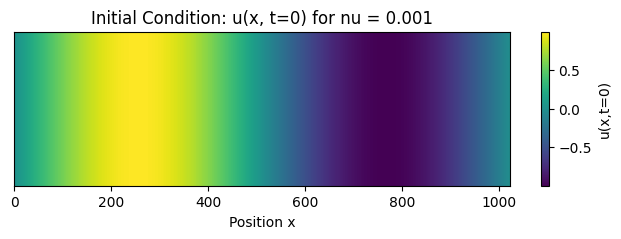

In [169]:
initial_field, full_trajectory, viscosity = dataset[0] # initial field for t = 0, full trajectory for nu = 0.001
# VISUALIZATION OF THE FIELD:
field_np = initial_field.numpy()

plt.figure(figsize=(8, 2))
plt.imshow(field_np[np.newaxis, :], aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='u(x,t=0)')
plt.xlabel('Position x')
plt.title(f'Initial Condition: u(x, t=0) for nu = 0.001')
plt.yticks([])
plt.show()


#### CNN controller

* Construct CNN that acts as the controller to process each patch.

* Typical architecture: input layer of patch size, one or two convolutional layers with kernel sizes equal or smaller than the patch size, nonlinear activations (ReLU or tanh), and output layer producing updated values for the center point in the patch.

* The CNN processes patches independently across the field.


In [170]:
# CNN controller definition:
# INPUTS: patch (spatial neighbourhood of the field) and nu (the viscosity).
# shape: (x, y, z)
# x = batch_size (number of patches you process at once).
# y = no. of output feature maps produced.
# z = output sequence length.
class CNNController(nn.Module):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size
        # Two input channels (in_channels = 2): field patch and viscosity
        # First convolutional layer:
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=32, kernel_size=patch_size, padding=0) # output shape: (batch_size, 32, 1).
        # ReLU activation function -> introduces non-linearity
        self.activation1 = nn.ReLU()
        # Add batch normalization for better training stability
        self.bn1 = nn.BatchNorm1d(32)
        # Second convolutional layer: kernel_size = 1 since this layer only considers the current point and not neighbouring points.
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1)
        # ReLU activation function -> introduces non-linearity
        self.activation2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(64)
        # Pooling layer -> reduce to single value
        self.pool = nn.AdaptiveMaxPool1d(1) # pooling reduces spatial dimension to 1 before fully connected
        # Connected layer:
        self.final_fc = nn.Sequential(
            nn.Flatten(start_dim=1), # flattens feature map to size (batch_size, 32)
            nn.Linear(64, 64), # maps all 64 features into 64 outputs
            # the predicted value at the next time step at the center of the patch.
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,1) # maps all 64 features into a single output.
        )

    def forward(self, patch, nu):
        # patch: (batch_size, patch_size)
        # nu: (batch_size, 1)
        patch = patch.unsqueeze(1) # (batch_size, 1, patch_size)
        nu_channel = nu.unsqueeze(2).expand(-1, -1, patch.shape[2]) # (batch_size, 2, patch_size)
        
        # Concatenate channels
        x = torch.cat([patch, nu_channel], dim=1)  # x shape: (batch_size, 2, patch_size)
        # First convolutional layer: takes 2 input channels and outputs 16 feature maps.
        x = self.conv1(x)  # (batch_size, 32, 1)
        x = self.bn1(x)
        # ReLU activation function:
        x = self.activation1(x)
        # Second convolutional layer: takes 32 input channels and outputs 32 output channels.
        x = self.conv2(x)  # (batch_size, 64, 1)
        x = self.bn2(x)
        # ReLU activation function:
        x = self.activation2(x)
        # Reduce each filter's output to a single value using pooling layer:
        x = self.pool(x)  # (batch_size, 64, 1)
        x = x.view(x.shape[0], -1) # (batch_size, 64)
        x = self.final_fc(x)  # (batch_size, 1)
        return x
    

    
# Create CNN controller for our NFTM:
cnn_controller = CNNController(patch_size = 3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_controller.to(device)

CNNController(
  (conv1): Conv1d(2, 32, kernel_size=(3,), stride=(1,))
  (activation1): ReLU()
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
  (activation2): ReLU()
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AdaptiveMaxPool1d(output_size=1)
  (final_fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

#### Read/Write head

* The controller reads patches, computes local updates, and writes these updates back into the corresponding local regions of the field.

* Reading: extract patches (local neighbourhoods) centered at each spatial position. These patches have shape `(batch_size, N, patch_size)`.

* Need to **reshape** patches to `(batch_size * N, 1, patch_size)`, to go as **input** into the CNN controller. This enables the CNN to process all patches in parallel as separate inputs in a batch.

* We treat each patch (local neighbours) as a separate 1D sample with 1 channel + length equal to patch_size.

* CNN **outputs** a **scalar value** per patch, with shape: `(batch_size * N, 1, 1)`.

* Need to **reshape** back to the field shape: `(batch_size,  N)`.

* Writing: updating the field.


In [171]:
# We pass as argument the batch of fields.
def extract_patches(fields_batch, patch_radius=1):
    # fields_batch shape: (batch_size, N)
    batch_size, N = fields_batch.shape
    x = fields_batch.unsqueeze(1)  # (batch_size, 1, N)
    pad = nn.ReplicationPad1d(patch_radius)
    padded = pad(x)  # (batch_size, 1, N + 2*patch_radius)
    patches = padded.unfold(dimension=2, size=2*patch_radius+1, step=1)  # (batch_size, 1, N, patch_size)
    patches = patches.squeeze(1)  # (batch_size, N, patch_size)
    return patches

#### Loss Function

* A common choice for the cost function is the MSE: $$L_{MNE} = \frac{1}{N} \sum_{i = 1}^{N} \sum_{t = 1}^{T} (u_{i,t} - \hat u_{i,t})^2$$

* N = no. spatial points at each time snapshot.

* T = no. of time snapshots where solution is considered.

* $\hat u_{i,t}$ = NFTM's predicted velocity at spatial point $i$ and time $t$.

* $u_{i,t}$ = truth velocity at spatial point $i$ and time $t$.

* The error between predicted values and truth solutions from your training data at different time steps.

In [172]:
mse_loss = nn.MSELoss() # LOSS FUNCTION

#### Optimizer

* We backpropagate the loss and update the CNN controller's weights using an optimizer.

    * Clear the gradients before backpropagation: `optimizer.zero_grad()`.

    * Compute gradients of the loss with respect to model parameters (backpropagation): `loss.backward()`.

    * Update the model parameters using the computed gradients: `optimizer.step()`.

* We can use the Adam optimizer among others.

In [173]:
optimizer = torch.optim.Adam(cnn_controller.parameters(), lr=1e-4) # OPTIMIZER

#### Training Loop: 10 epochs

* Each batch represents a different initial condition/starting field (a spatial field $u(x,t=0)$) and associated training data (whole solution field $u(x,t)$ for all spatial positions $x$ and all time steps $t$ for a given viscosity $\nu$).

* For each batch separately, the model simulates the temporal evolution by iteratively updating the continuous field in time from this batch's initial condition.

* Within processing a single batch, the continuous field is evolved over all time steps $t=0,...T-1$.

* After completing the full time evolution for that batch (reaching $t=T$), the training loss is computed comparing the full predicted trajectory to the true trajectory for that batch.

* This is done independently for each batch in the training dataset. 

In [165]:
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

cnn_controller.train()
# optimizer = torch.optim.Adam(cnn_controller.parameters(), lr=1e-4)  # possibly lower LR here
# mse_loss = nn.MSELoss()
num_epochs = 10
epoch_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for initial_fields_batch, true_trajectories_batch, viscosities_batch in train_loader:
        initial_fields_batch = initial_fields_batch.to(device)       # (batch_size, N)
        true_trajectories_batch = true_trajectories_batch.to(device) # (batch_size, T, N)
        viscosities_batch = viscosities_batch.to(device)             # (batch_size, 1)

        batch_size, T, N = true_trajectories_batch.shape

        # Predict next step for every time step independently, no autoregressive rollout:
        pred_trajectory = []
        
        for t in range(T - 1):
            current_field = true_trajectories_batch[:, t, :]  # ground truth at time t (batch, N)
            next_true = true_trajectories_batch[:, t + 1, :]  # ground truth at t+1 for loss
            
            patches = extract_patches(current_field, patch_radius=1)  # (batch, N, patch_size)
            patches_reshape = patches.reshape(batch_size * N, -1)     # (batch*N, patch_size)
            # expand viscosity for each patch
            viscosity_expanded = viscosities_batch.unsqueeze(1).expand(-1, N, -1).reshape(batch_size * N, 1)  # (batch*N, 1)
            # predict each field
            next_pred = cnn_controller(patches_reshape, viscosity_expanded).reshape(batch_size, N)

            pred_trajectory.append(next_pred)

        # Stack along time: (batch, T-1, N)
        pred_trajectory = torch.stack(pred_trajectory, dim=1)

        # Target - true trajectory excluding initial time step: (batch, T-1, N)
        target_trajectory = true_trajectories_batch[:, 1:, :]

        loss = mse_loss(pred_trajectory, target_trajectory)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")








# train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# num_epochs = 20  # adjust as needed
# epoch_losses = []  # list to store average loss per epoch
# # fields_history = []  # Optionally store predictions for heatmap
# cnn_controller.train()

# for epoch in range(num_epochs):
#     epoch_loss = 0.0
#     for initial_fields_batch, true_trajectories_batch, viscosities_batch in train_loader:
#         # Move to device
#         initial_fields_batch = initial_fields_batch.to(device)       # (batch_size, N)
#         true_trajectories_batch = true_trajectories_batch.to(device) # (batch_size, T, N)
#         viscosities_batch = viscosities_batch.to(device)       # (batch_size, 1)

#         batch_size, T, N = true_trajectories_batch.shape
#         pred_trajectory = [initial_fields_batch] # for t = 0

#         current_fields = initial_fields_batch
        
#         for t in range(T-1):
#             patches = extract_patches(current_fields, patch_radius=1)  # (batch, N, patch_size)
#             # Flatten batch and spatial dims
#             patches_reshape = patches.reshape(batch_size * N, -1)  # (batch*N, patch_size)
#             # Repeat viscosity for each spatial position
#             viscosity_expanded = viscosities_batch.unsqueeze(1).expand(-1, N, -1).reshape(batch_size * N, 1)  # (batch*N, 1)
            
#             next_field_pred = cnn_controller(patches_reshape, viscosity_expanded).reshape(batch_size, N)  # (batch, N)
            
#             current_fields = next_field_pred
#             pred_trajectory.append(current_fields)
#         # Stack along time dimension: (batch, T, N)
#         pred_trajectory = torch.stack(pred_trajectory, dim=1)
        
#         # Compute loss compared to true_trajectory (T, N)

#         loss = mse_loss(pred_trajectory, true_trajectories_batch)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     avg_loss = epoch_loss / len(train_loader)
#     epoch_losses.append(avg_loss)    
#     print(f'Epoch {epoch+1}, Loss {avg_loss}')



# for epoch in range(num_epochs):
#     epoch_loss = 0
#     for initial_field_batch, true_trajectory_batch, viscosity_batch in train_loader:
#         batch_pred = []
#         for i, (initial_field, true_trajectory, viscosity) in enumerate(zip(initial_field_batch, true_trajectory_batch, viscosity_batch)):
#             pred_trajectory = [initial_field]
#             for t in range(T-1):
#                 current_field = pred_trajectory[-1]
#                 patches = extract_patches(current_field)
#                 viscosity_channel = torch.full((patches.shape[0], 1), float(viscosity))
#                 next_field_values = cnn_controller(patches, viscosity_channel)
#                 pred_trajectory.append(next_field_values)
#             pred_trajectory = torch.stack(pred_trajectory, dim=0)  # (T, N)
#             batch_pred.append(pred_trajectory)
#         batch_pred = torch.stack(batch_pred, dim=0)  # (batch_size, T, N)

#         loss = mse_loss(batch_pred, true_trajectory_batch)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     print(f'Epoch {epoch+1}, Loss {epoch_loss / len(train_loader)}')


# for epoch in range(num_epochs):
#     epoch_loss = 0
#     for initial_field_batch, true_trajectory_batch, viscosity_batch in train_loader:
#         batch_pred = []
#         # Iterate over each sample in batch (field, full trajectory, viscosity)
#         for i, (initial_field, true_trajectory, viscosity) in enumerate(zip(initial_field_batch, true_trajectory_batch, viscosity_batch)):
#             pred_trajectory = [initial_field.to(device)]
#             viscosity_scalar = viscosity.to(device).unsqueeze(0)

#             for t in range(true_trajectory.shape[0] - 1):  # T time steps
#                 # current_field = pred_trajectory[-1]
#                 current_field = current_field.clone().detach().requires_grad_()

#                 patches = extract_patches(current_field, patch_radius=1).to(device)  # (N, patch_size)
                
#                 # Expand viscosity to batch size = number of patches (positions)
#                 viscosity_channel = viscosity_scalar.expand(patches.shape[0], 1)

#                 print(f'current_field shape: {current_field.shape}, dtype: {current_field.dtype}, device: {current_field.device}')
#                 patches = extract_patches(current_field, patch_radius=1)
#                 print(f'patches shape: {patches.shape}, dtype: {patches.dtype}, device: {patches.device}')
#                 patches = patches.to(device)
#                 print(f'patches moved to device: {patches.device}')
#                 viscosity_channel = viscosity_scalar.expand(patches.shape[0], 1).to(device)
#                 print(f'viscosity_channel shape: {viscosity_channel.shape}, device: {viscosity_channel.device}')
#                 next_field_values = cnn_controller(patches, viscosity_channel)
#                 print(f'next_field_values.shape: {next_field_values.shape}')



#                 print(current_field.requires_grad)
#                 patches = extract_patches(current_field, patch_radius=1).to(device)
#                 print(patches.requires_grad)
#                 viscosity_channel = viscosity_scalar.expand(patches.shape[0], 1).to(device)
#                 print(viscosity_channel.requires_grad)
#                 next_field_values = cnn_controller(patches, viscosity_channel)
#                 print(next_field_values.requires_grad)


#                 next_field_values = cnn_controller(patches, viscosity_channel)
#                 pred_trajectory.append(next_field_values.squeeze(-1))  # (N,)
#                 print(pred_trajectory.shape)
#                 print(true_trajectory.shape)
#             pred_trajectory = torch.stack(pred_trajectory, dim=0)  # (T, N)
#             batch_pred.append(pred_trajectory)

    #     batch_pred = torch.stack(batch_pred, dim=0)  # (batch_size, T, N)

    #     loss = mse_loss(batch_pred, true_trajectory_batch.to(device))
    #     optimizer.zero_grad()
    #     loss.backward()
    #     optimizer.step()
    #     epoch_loss += loss.item()
    
    # print(f'Epoch {epoch+1}, Loss {epoch_loss/len(train_loader)}')



    # for epoch in range(num_epochs):
#     epoch_loss = 0.0
#     for patch, nu, target in train_loader:
#         patch, nu, target = patch.to(device), nu.to(device), target.to(device)
#         optimizer.zero_grad() # clear the gradients
#         predicted = cnn_controller(patch, nu)  # (batch_size, 1)
#         loss = mse_loss(predicted, target)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item() * patch.size(0)
#     avg_loss = epoch_loss / len(train_loader.dataset)
#     epoch_losses.append(avg_loss)
#     print(f"Epoch {epoch+1}/{num_epochs}: Loss={avg_loss:.6f}")



Epoch 1, Loss: 0.2503259778022766
Epoch 2, Loss: 0.2442885935306549
Epoch 3, Loss: 0.23843559622764587
Epoch 4, Loss: 0.23287323117256165
Epoch 5, Loss: 0.2271736115217209
Epoch 6, Loss: 0.22149570286273956
Epoch 7, Loss: 0.21604451537132263
Epoch 8, Loss: 0.21054650843143463
Epoch 9, Loss: 0.20507442951202393
Epoch 10, Loss: 0.1997055560350418


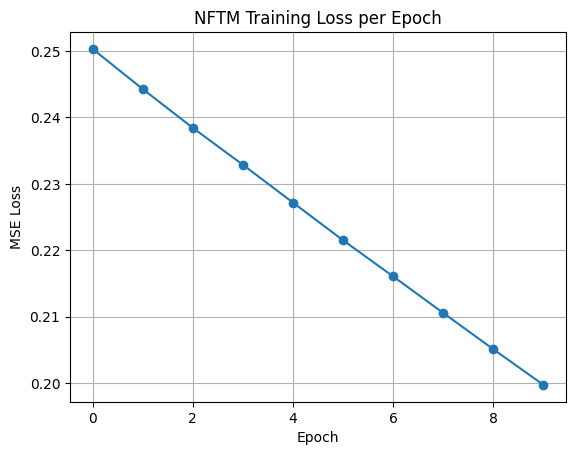

In [166]:
# Loss Evolution Plot
plt.figure()
plt.plot(epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('NFTM Training Loss per Epoch')
plt.grid(True)
plt.show()

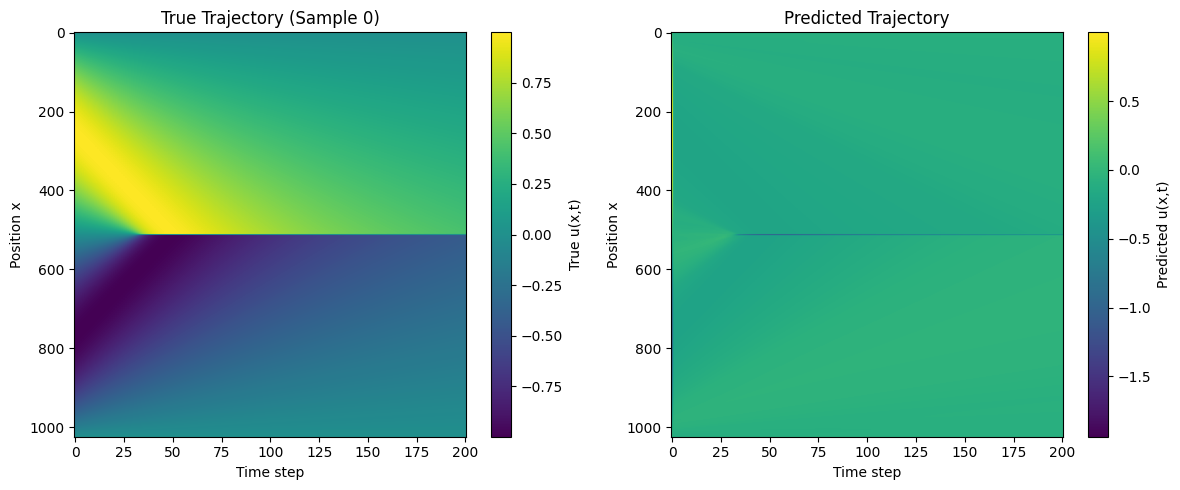

In [167]:
# Heatmap to compare the true and predicted solutions.
# Choose a viscosity and corresponding data set

# Choose a sample from your new dataset (e.g., index 0)
initial_field, true_trajectory, viscosity_val = dataset[0]

# with torch.no_grad():
#     u_pred = [initial_field.to(device)]  # initial field (N,)
#     T = true_trajectory.shape[0]
    
#     for t in range(T - 1):
#         current_field = u_pred[-1]
#         # Pad and extract patches using batch method for single item:
#         padded = torch.nn.functional.pad(current_field.unsqueeze(0), (1, 1), mode='replicate').squeeze(0)
#         patches = padded.unfold(0, 3, 1)  # (N, patch_size=3)
        
#         nu_vals = torch.full((patches.shape[0], 1), float(viscosity_val), device=device)  # (N,1)
        
#         next_u = cnn_controller(patches.to(device), nu_vals).squeeze(1)
#         u_pred.append(next_u)
    
#     u_pred = torch.stack(u_pred)  # (T, N)

# with torch.no_grad():
#     u_pred = [initial_field.to(device).unsqueeze(0)]  # (1, N) adding batch dim
#     T = true_trajectory.shape[0]
    
#     for t in range(T - 1):
#         current_field = u_pred[-1]  # (1, N)
#         patches = extract_patches(current_field, patch_radius=1)  # (1, N, patch_size=3)
#         patches_reshape = patches.reshape(-1, patches.shape[-1])  # (N, patch_size)
        
#         nu_vals = torch.full((patches_reshape.shape[0], 1), float(viscosity_val), device=device)  # (N,1)
#         next_u = cnn_controller(patches_reshape.to(device), nu_vals).squeeze(1)  # (N,)
        
#         u_pred.append(next_u.unsqueeze(0))  # add batch dimension back

#     u_pred = torch.cat(u_pred, dim=0)  # (T, N)


# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
# plt.imshow(true_trajectory.cpu().numpy().T, aspect='auto', cmap='viridis')
# plt.colorbar(label='True u(x,t)')
# plt.title(f'True Trajectory for nu = {viscosity_val.item()}')
# plt.xlabel('Time step t')
# plt.ylabel('Position x')

# plt.subplot(1, 2, 2)
# plt.imshow(u_pred.cpu().numpy().T, aspect='auto', cmap='viridis')
# plt.colorbar(label='Predicted u(x,t)')
# plt.title('NFTM Predicted Trajectory')
# plt.xlabel('Time step t')
# plt.ylabel('Position x')

# plt.tight_layout()
# plt.show()


# Set model to evaluation mode
cnn_controller.eval()

# Choose a sample index to visualize
sample_idx = 0
initial_field, true_trajectory, viscosity_val = dataset[sample_idx]

with torch.no_grad():
    # Move to device and prepare storage for predictions
    initial_field = initial_field.to(device)        # (N,)
    true_trajectory = true_trajectory.to(device)    # (T, N)
    T, N = true_trajectory.shape
    
    pred_trajectory = []
    
    for t in range(T - 1):
        current_field = true_trajectory[t]         # use ground truth for input at each step (matching training)
        patches = extract_patches(current_field.unsqueeze(0), patch_radius=1)  # (1, N, patch_size)
        patches_reshape = patches.reshape(-1, patches.shape[-1])               # (N, patch_size)
        
        nu_vals = torch.full((patches_reshape.shape[0], 1), float(viscosity_val), device=device)
        
        next_pred = cnn_controller(patches_reshape, nu_vals).squeeze(1)        # (N,)
        pred_trajectory.append(next_pred)

    # Stack predicted fields (T-1, N), prepend initial condition for full T steps
    pred_trajectory = torch.stack(pred_trajectory, dim=0)
    pred_trajectory = torch.cat([initial_field.unsqueeze(0), pred_trajectory], dim=0)

# Convert to cpu numpy for plotting
true_np = true_trajectory.cpu().numpy().T       # (N, T)
pred_np = pred_trajectory.cpu().numpy().T       # (N, T)

# Plot heatmaps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(true_np, aspect='auto', cmap='viridis')
plt.colorbar(label='True u(x,t)')
plt.title(f'True Trajectory (Sample {sample_idx})')
plt.xlabel('Time step')
plt.ylabel('Position x')

plt.subplot(1, 2, 2)
plt.imshow(pred_np, aspect='auto', cmap='viridis')
plt.colorbar(label='Predicted u(x,t)')
plt.title('Predicted Trajectory')
plt.xlabel('Time step')
plt.ylabel('Position x')

plt.tight_layout()
plt.show()



#### Training Loop: 20 epochs

In [174]:
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

cnn_controller.train()
num_epochs = 20
epoch_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for initial_fields_batch, true_trajectories_batch, viscosities_batch in train_loader:
        initial_fields_batch = initial_fields_batch.to(device)       # (batch_size, N)
        true_trajectories_batch = true_trajectories_batch.to(device) # (batch_size, T, N)
        viscosities_batch = viscosities_batch.to(device)             # (batch_size, 1)

        batch_size, T, N = true_trajectories_batch.shape

        # Predict next step for every time step independently, no autoregressive rollout:
        pred_trajectory = []
        
        for t in range(T - 1):
            current_field = true_trajectories_batch[:, t, :]  # ground truth at time t (batch, N)
            next_true = true_trajectories_batch[:, t + 1, :]  # ground truth at t+1 for loss
            
            patches = extract_patches(current_field, patch_radius=1)  # (batch, N, patch_size)
            patches_reshape = patches.reshape(batch_size * N, -1)     # (batch*N, patch_size)
            # expand viscosity for each patch
            viscosity_expanded = viscosities_batch.unsqueeze(1).expand(-1, N, -1).reshape(batch_size * N, 1)  # (batch*N, 1)
            # predict each field
            next_pred = cnn_controller(patches_reshape, viscosity_expanded).reshape(batch_size, N)

            pred_trajectory.append(next_pred)

        # Stack along time: (batch, T-1, N)
        pred_trajectory = torch.stack(pred_trajectory, dim=1)

        # Target - true trajectory excluding initial time step: (batch, T-1, N)
        target_trajectory = true_trajectories_batch[:, 1:, :]

        loss = mse_loss(pred_trajectory, target_trajectory)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

Epoch 1, Loss: 0.24892863631248474
Epoch 2, Loss: 0.24324725568294525
Epoch 3, Loss: 0.23778055608272552
Epoch 4, Loss: 0.23237644135951996
Epoch 5, Loss: 0.22682489454746246
Epoch 6, Loss: 0.22151008248329163
Epoch 7, Loss: 0.216379314661026
Epoch 8, Loss: 0.2111365646123886
Epoch 9, Loss: 0.20603923499584198
Epoch 10, Loss: 0.20118115842342377
Epoch 11, Loss: 0.19643710553646088
Epoch 12, Loss: 0.19170354306697845
Epoch 13, Loss: 0.18695423007011414
Epoch 14, Loss: 0.1823922097682953
Epoch 15, Loss: 0.1780162751674652
Epoch 16, Loss: 0.17374837398529053
Epoch 17, Loss: 0.16934870183467865
Epoch 18, Loss: 0.16522067785263062
Epoch 19, Loss: 0.16108042001724243
Epoch 20, Loss: 0.1571575254201889


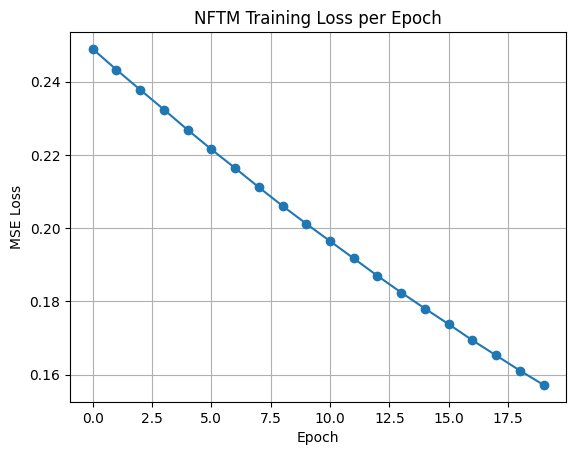

In [175]:
# Loss Evolution Plot
plt.figure()
plt.plot(epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('NFTM Training Loss per Epoch')
plt.grid(True)
plt.show()

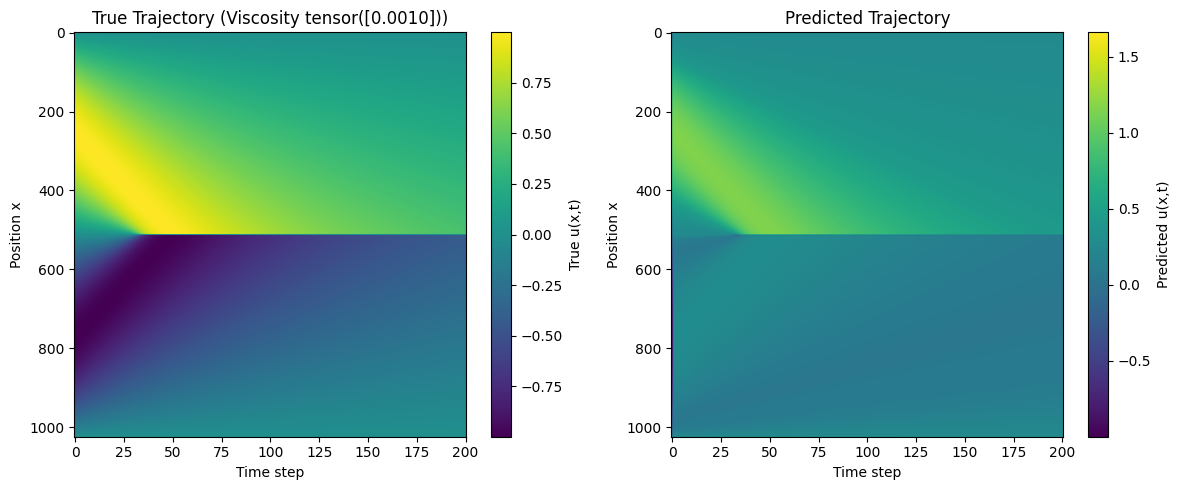

In [177]:
# Heatmap to compare the true and predicted solutions.

# Choose a sample from your new dataset (e.g., index 0)
initial_field, true_trajectory, viscosity_val = dataset[0]

# Set model to evaluation mode
cnn_controller.eval()

# Choose a sample index to visualize
sample_idx = 0
initial_field, true_trajectory, viscosity_val = dataset[sample_idx]

with torch.no_grad():
    # Move to device and prepare storage for predictions
    initial_field = initial_field.to(device)        # (N,)
    true_trajectory = true_trajectory.to(device)    # (T, N)
    T, N = true_trajectory.shape
    
    pred_trajectory = []
    
    for t in range(T - 1):
        current_field = true_trajectory[t]         # use ground truth for input at each step (matching training)
        patches = extract_patches(current_field.unsqueeze(0), patch_radius=1)  # (1, N, patch_size)
        patches_reshape = patches.reshape(-1, patches.shape[-1])               # (N, patch_size)
        
        nu_vals = torch.full((patches_reshape.shape[0], 1), float(viscosity_val), device=device)
        
        next_pred = cnn_controller(patches_reshape, nu_vals).squeeze(1)        # (N,)
        pred_trajectory.append(next_pred)

    # Stack predicted fields (T-1, N), prepend initial condition for full T steps
    pred_trajectory = torch.stack(pred_trajectory, dim=0)
    pred_trajectory = torch.cat([initial_field.unsqueeze(0), pred_trajectory], dim=0)

# Convert to cpu numpy for plotting
true_np = true_trajectory.cpu().numpy().T       # (N, T)
pred_np = pred_trajectory.cpu().numpy().T       # (N, T)

# Plot heatmaps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(true_np, aspect='auto', cmap='viridis')
plt.colorbar(label='True u(x,t)')
plt.title(f'True Trajectory (Viscosity {viscosity_val})')
plt.xlabel('Time step')
plt.ylabel('Position x')

plt.subplot(1, 2, 2)
plt.imshow(pred_np, aspect='auto', cmap='viridis')
plt.colorbar(label='Predicted u(x,t)')
plt.title('Predicted Trajectory')
plt.xlabel('Time step')
plt.ylabel('Position x')

plt.tight_layout()
plt.show()


### Error heatmap

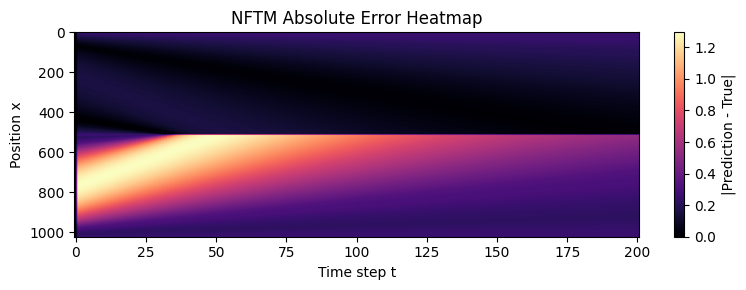

In [182]:
# Error at each grid point and time
# pred_trajectory: tensor of predicted solution (T, N)
# true_trajectory: tensor of true solution (T, N)

# Convert to numpy for error computation
pred_np = pred_trajectory.cpu().numpy()      # shape (T, N)
true_np = true_trajectory.cpu().numpy()      # shape (T, N)

# Compute absolute error at each time step and position
abs_error = np.abs(pred_np - true_np)        # shape (T, N)

plt.figure(figsize=(8, 3))
plt.imshow(abs_error.T, aspect='auto', cmap='magma')  # Transpose to show position on y-axis
plt.colorbar(label='|Prediction - True|')
plt.xlabel('Time step t')
plt.ylabel('Position x')
plt.title('NFTM Absolute Error Heatmap')
plt.tight_layout()
plt.show()


Summary of the Architecture:

* Input: 1D spatial field representing $u(x,t)$.

* Patch extraction: Sliding local neighborhoods of radius $r$.

* Controller: CNN processing each local patch.

* Update: Local field value updates returned by CNN.

* Iteration: Time-stepping loop applying CNN update repeatedly.

* Output: Predicted evolution of $u(x,t)$ over time.

This setup lets you build an end-to-end differentiable NFTM that learns local update rules via convolutional kernels, naturally capturing the physics of the 1D Burgers equation with your training data.